In [1]:
import tensorflow as tf
import numpy as np
from time import time
from reader import ptb_raw_data

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data, valid_data, test_data, word_to_id = ptb_raw_data('data')
id_to_word = {i: k for k, i in word_to_id.iteritems()}
vocab_size = len(word_to_id)
num_steps = 20
hidden_size = 200
batch_size = 20
num_layers = 2 # Number of stacked LSTMs
dropout = 0.9 # Proba to keep neurons
max_grad_norm = 5.0 # Maximum norm of gradient
init_scale = 0.1 # Weights initialization scale
initial_lr = 1.0
lr_decay = 0.5
max_epoch_no_decay = 4 # Number of epochs not decaying learning rate
nb_epochs = 10 # Maximum number of epochs

In [6]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.int32, [None, num_steps])
target = tf.placeholder(tf.int32, [None, num_steps])
learning_rate = tf.Variable(initial_lr, trainable=False)
# Use a placeholder to turn off dropout during testing 
keep_prob = tf.placeholder(tf.float32)
def build_graph():
    # Word embedding
    embedding = tf.get_variable('embedding', [vocab_size, hidden_size])
    input_embed = tf.nn.embedding_lookup(embedding, input_data)
    input_embed_dropout = tf.nn.dropout(input_embed, keep_prob)

    # LSTM
    def lstm_cell():
        return tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=1.0)
    def lstm_cell_dropout():
        return tf.contrib.rnn.DropoutWrapper(lstm_cell(), output_keep_prob=keep_prob)
    hidden_cell = lstm_cell_dropout
    cell = tf.contrib.rnn.MultiRNNCell([hidden_cell() for _ in range(num_layers)], state_is_tuple=True)
    initial_state = cell.zero_state(batch_size, tf.float32)

    state = initial_state
    outputs = []
    with tf.variable_scope('RNN'):
        for t in range(num_steps):
            if t > 0: tf.get_variable_scope().reuse_variables() # Reuse the weights in the LSTMs
            output, state = cell(input_embed_dropout[:, t, :], state)
            outputs.append(output)
    final_state = state

    h1 = tf.reshape(tf.stack(outputs, axis=1), [-1, hidden_size])
    W_softmax = tf.get_variable('W_softmax', [hidden_size, vocab_size])
    b_softmax = tf.get_variable('b_softmax', [vocab_size])
    logits = tf.matmul(h1, W_softmax) + b_softmax
    logits = tf.reshape(logits, [batch_size, num_steps, vocab_size])
    # Use sequence loss for average over batch and sum across timesteps
    loss_vector = tf.contrib.seq2seq.sequence_loss(logits, target, weights=tf.ones([batch_size, num_steps]),
                                                   average_across_batch=True, average_across_timesteps=False)
    loss = tf.reduce_sum(loss_vector)
    # Use gradient cliping
    trainable_vars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), max_grad_norm)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.apply_gradients(zip(grads, trainable_vars),
                                           global_step=tf.contrib.framework.get_or_create_global_step())

    correct_pred = tf.equal(tf.cast(tf.argmax(tf.reshape(logits, [-1, vocab_size]), 1), tf.int32), 
                            tf.reshape(target, [-1]))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return initial_state, final_state, loss, accuracy, train_step

In [7]:
def run_model(sess, data, is_training, lr_decay=0.5, nb_epochs=1, show_loss_graph=True):
    batch_len = data.shape[0] / batch_size
    data = data[: batch_len * batch_size].reshape((batch_size, batch_len))
    epoch_size = (batch_len - 1) / num_steps
    if is_training:
        # Iteration to print at
        print_iter = list(np.linspace(0, epoch_size - 1, 11).astype(int))
        initializer = tf.random_uniform_initializer(-init_scale, init_scale)    
        with tf.variable_scope('Model', reuse=None, initializer=initializer):
            initial_state, final_state, loss, accuracy, train_step = build_graph()
        sess.run(tf.global_variables_initializer())
        # Dropout parameter
        dropout_param = dropout
        ops = [final_state, loss, accuracy, train_step]
    else:
        with tf.variable_scope('Model', reuse=True):
            initial_state, final_state, loss, accuracy, train_step = build_graph()
        dropout_param = 1.0
        ops = [final_state, loss, accuracy, tf.no_op()]

    for e in range(nb_epochs):
        print ('Epoch: {0}'.format(e + 1))
        lr_decay = lr_decay ** max(e + 1 - max_epoch_no_decay, 0)
        sess.run(tf.assign(learning_rate, initial_lr * lr_decay))

        total_loss = 0.0
        total_accuracy = 0.0
        nb_iter = 0.0
        perplexity_history = []
        numpy_state = sess.run(initial_state)
        t0 = time()
        for i in range(epoch_size):
            curr_input = data[:, i * num_steps: (i + 1) * num_steps]
            # Target is the input shifted in time by 1
            curr_target = data[:, i * num_steps + 1: (i + 1) * num_steps + 1]
            numpy_state, curr_loss, curr_acc, _ = sess.run(ops,
                                                           feed_dict={input_data: curr_input, 
                                                                      target: curr_target,
                                                                      initial_state: numpy_state, 
                                                                      keep_prob: dropout_param})
            total_loss += curr_loss
            total_accuracy += curr_acc
            nb_iter += num_steps
            perplexity_history.append(np.exp(curr_loss / num_steps))

            if (is_training and i in print_iter):
                print('{0:.0f}% perplexity = {1:.3f}, accuracy = {2:.3f}, speed = {3:.0f} wps'\
                      .format(print_iter.index(i) * 10, 
                              np.exp(total_loss / nb_iter), total_accuracy / (i + 1),
                              (nb_iter * batch_size) / (time() - t0)))
        if not is_training:
            print('Perplexity = {0:.3f}, accuracy = {1:.3f}, speed = {2:.0f} wps'\
                  .format(np.exp(total_loss / nb_iter), total_accuracy / (i + 1),
                          (nb_iter * batch_size) / (time() - t0)))

        if (is_training and show_loss_graph):
            plt.plot(perplexity_history)
            plt.grid(True)
            plt.title('Epoch {0}'.format(e + 1))
            plt.xlabel('Mini-batch number')
            plt.ylabel('Perplexity per mini-batch')
            plt.show()

Training:
Epoch: 1
0% perplexity = 10102.463, accuracy = 0.000, speed = 685 wps
10% perplexity = 7093.925, accuracy = 0.044, speed = 1147 wps
20% perplexity = 4537.125, accuracy = 0.045, speed = 1188 wps
30% perplexity = 3220.060, accuracy = 0.043, speed = 1202 wps
40% perplexity = 2522.724, accuracy = 0.044, speed = 1198 wps
50% perplexity = 2178.471, accuracy = 0.045, speed = 1195 wps
60% perplexity = 1939.284, accuracy = 0.046, speed = 1192 wps
70% perplexity = 1747.422, accuracy = 0.047, speed = 1188 wps
80% perplexity = 1655.574, accuracy = 0.048, speed = 1170 wps
90% perplexity = 1558.676, accuracy = 0.049, speed = 1161 wps
100% perplexity = 1455.289, accuracy = 0.050, speed = 1157 wps


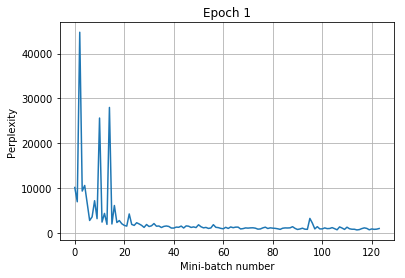


Validation:
Epoch: 1
Perplexity = 806.593, accuracy = 0.055, speed = 3060 wps


In [8]:
with tf.Session() as sess:
    print('Training:')
    run_model(sess, train_data[:50000], lr_decay=lr_decay, is_training=True, nb_epochs=1)
    print('\nValidation:')
    run_model(sess, valid_data, is_training=False, nb_epochs=1)